<a href="https://colab.research.google.com/github/pmaher86/continuous-time-consumption/blob/main/Continuous_Time_Consumption_Under_Certainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring a continuous time consumption-under-certainty model in Python

This is a short example of how we can extend a simple contrained optimization economics model to continuous time using calculus of variations, as well as an example of how we can explore a model both analytically and numerically using  common Python packages.

## Setup
First off, we'll need a newer version of [SymPy](https://www.sympy.org/en/index.html) than the current default in Colab.

In [ ]:
!pip install --upgrade sympy

     |████████████████████████████████| 5.9MB 5.3MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


Now let's import some packages we'll need and set some styling.

In [ ]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import functools
from scipy.integrate import odeint
from scipy.optimize import root_scalar, minimize, NonlinearConstraint
from scipy.interpolate import interp1d

In [ ]:
sym.init_printing()
plt.style.use('seaborn-talk')

# Introduction
A standard economics model for maximizing consumption under certainty (see: [here](https://www.econ.berkeley.edu/sites/default/files/course-homepage/2015-11-11/lecture-notes/Notes_Consumption_pog.pdf)) looks something like 
$$
U = \sum_t \beta_t u(c_t)
$$
where $U$ is the overall utility to be maximized, $t$ is time, $\beta_t$ is the discount factor at time $t$, $u$ is the utility function of consumption, and $c_t$ is the consumption at time $t$.

Additionally, we have a few other variables: $A_t$ (overall wealth at time $t$), $y_t$ (income at time $t$), and $R$, the rate of return on wealth. These are related by the intertemporal equation $A_{t+1} = R(A_t + y_t - c_t)$. Together with some constraints (typically that $A_T \geq 0$ at some finite time $T$), and specification of initial conditions, this becomes an optimization problem that can solved with [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier).

## Continuous Time
As an erstwhile physicist, there's something dissatisfying about working this problem in discrete time. This recursive "update rule" invites being rewritten as 
$$A_{t+1} - A_t = (R-1)A_t + Ry_t - Rc_t$$
which is clearly suggestive of a differential equation in the continuous time limit. But first, a little smudging and redifintion to clean things up. One, we'll allow $y$ and $c$ to absorb the factors of $R$ beside them. We can imagine this as a slight change of the rules—that interest is not paid on income or consumption for the current time periods—and it should make intuitive sense that that shouldn't alter behavior substantially, especially as time periods become short. Alternately, we can imagine it as a redifintion of consumption and income, and note that scaling them by a constant shouldn't change the overall dynamics of the problem. Let's also then map $(R-1)\rightarrow R$, so that instead of $R>1$ defining a positive interest rate we now have $R>0$. 

We can then write down the continuous time equations

$$U = \int\beta(t)u(c(t))$$
$$\frac{d}{dt}A(t)=RA(t) + y(t) -c(t)$$

The goal is now to find a fuction $c(t)$ that maximizes $U$. This is a textbook [calculus of variations](https://en.wikipedia.org/wiki/Calculus_of_variations) problem. Let's get started by building our [Lagrangian](https://en.wikipedia.org/wiki/Lagrangian_mechanics) in SymPy.

In [ ]:
t, beta, u, c = sym.Symbol('t'), sym.Function('beta'), sym.Function('u'), sym.Function('c')

L = beta(t) * u(c(t))
L

Now let's write our our update equation.

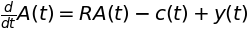

In [ ]:
A = sym.Function('A') 
y = sym.Function('y')
R = sym.Symbol('R', positive=True)
update_eq = sym.Eq(A(t).diff(t), R*A(t) + y(t) - c(t))
update_eq

And we'll use it to rewrite the Lagrangian as an explicit function of $A$.

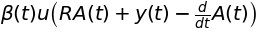

In [ ]:
c_fn_of_A = sym.solve(update_eq, c(t))[0]
L_explicit = L.subs(c(t), c_fn_of_A)
L_explicit

# A naive solution

In order to proceed futher, we'll need to start choosing some concrete functional forms. We'll use the common approach of a logarithmic utility function. To keep the problem analytically tractable, let's start with the rather unrealistic assumption of no discount factor ($\beta(t)=1$).

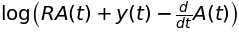

In [ ]:
L_simple = L_explicit.subs(u, sym.log).subs(beta(t), 1)
L_simple

## Finding the equation of motion
Let's now find the [Euler-Lagrange equation](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation) for this system, which describes the extrema. 

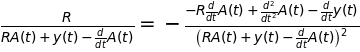

In [ ]:
EL_eq = sym.Eq(L_simple.diff(A(t)), L_simple.diff(A(t).diff(t)).diff(t))
# We could also use SymPy's built in Euler equations function
# EL_eq = sym.calculus.euler.euler_equations(L_simple, funcs=[A(t)], vars=[t])[0]
EL_eq

SymPy's automatic simplification routines will hit their limits as we start to move into more complicated equations, so we'll have to do some manual tidying here and there.

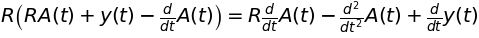

In [ ]:
def cancel_eq_denom(eq: sym.Eq, denom: sym.Expr) -> sym.Eq:
  return sym.Eq(sym.simplify(eq.lhs*denom), sym.simplify(eq.rhs*denom)) 

EL_eq_simple = cancel_eq_denom(EL_eq, c_fn_of_A**2)
EL_eq_simple

This looks promising! Specifically, it's a [nonhomogeneous](https://math.libretexts.org/Bookshelves/Calculus/Book%3A_Calculus_(OpenStax)/17%3A_Second-Order_Differential_Equations/17.2%3A_Nonhomogeneous_Linear_Equations) second-order [ordinary differential equation](https://en.wikipedia.org/wiki/Ordinary_differential_equation). To solve it, we'll need to pick a form for $y(t)$. We'll use $y(t)=e^{wt}$, where $w$ is a parameter that describes the rate of wage growth which is different than $R$. Intuitively, the interesting cases occur when $R>w$, otherwise wealth and consumption are dominated by wages as $t$ grows.

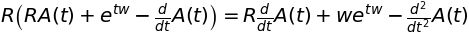

In [ ]:
w = sym.Symbol('w', positive=True)
y_explicit = sym.exp(w*t)
EL_explicit = sym.simplify(EL_eq_simple.subs(y(t), y_explicit))
EL_explicit

## Characterizing the solutions
And now, time to solve!

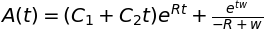

In [ ]:
sym.dsolve(EL_explicit, A(t))

As expected, our solution contains two constants of integration. We'll need to specify boundary conditions to eliminate them. Additionally, note the factor of $t$ with $C_2$—this comes from the fact that the homogenous part of our ODE has [repeated roots](https://math.libretexts.org/Bookshelves/Analysis/Supplemental_Modules_(Analysis)/Ordinary_Differential_Equations/3%3A_Second_Order_Linear_Differential_Equations/3.4%3A_Repeated_Roots_and_Reduction_of_Order) of $R$ for the characteristic equation.

Let's plug in constants for initial wealth and its derivative.

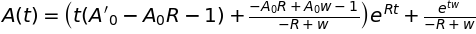

In [ ]:
A_0 = sym.Symbol('A_0')
dA_dt_0 = sym.Symbol("A'_0")
A_sol = sym.dsolve(EL_explicit, A(t), ics={A(0): A_0, A(t).diff(t).subs(t,0): dA_dt_0})
A_sol

So this is our full solution for wealth as a function of time. While, we're at it, let's also look at consumption as a function of time.

In [ ]:
sym.factor(
  sym.cancel(
    sym.simplify(c_fn_of_A.subs(A(t), A_sol.rhs).subs(y(t), y_explicit))
  )
)

Here's our first surprise, *consumption does not dynamically depend on $w$, only $R$*. This might not have seemed obvious at first glance! Of course, we still have the free constants $A_0$ and $A'_0$ which could implicitly depend on $w$. To understand what to do with those, let's go back and integrate our Lagrangian up to some time $T$. (We'll need to do some manual simplification to help SymPy).

In [ ]:
T = sym.Symbol('T', positive=True)
integral = sym.integrate(sym.log(sym.cancel(sym.simplify(c_fn_of_A.subs(A(t), A_sol.rhs).subs(y(t), y_explicit)))), (t,0,T))
sym.collect(sym.factor(integral), (1+ A_0*R - dA_dt_0))

We will consider $A_0$ to be given as a paramter of the problem, but we wish to allow a choice of any $A'_0$ so as to maximize the overall utility. As we can see, though, $U\rightarrow \infty$ as $A'_0\rightarrow-\infty$.

Thus, without any constraint, the optimal strategy is infinite consumption enabled by infinite borrowing (negative wealth accumuluation). In order to make the problem more sensible let's amend it slightly—we'll consider maximizing consumption over some finite time period $T$, with the constraint that $A(T) \geq 0$. We can translate this into a constraint on $A'_0$:

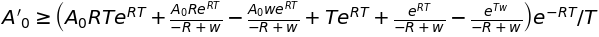

In [ ]:
sym.solve(A_sol.rhs.subs(t,T) >= 0, dA_dt_0)

Because our integral is negative monontonic in $A'_0$, our maximal solution will be at the equality point. Let's plug this back into our solution for $A$.

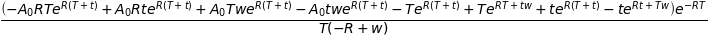

In [ ]:
dA_dt_0_max = sym.solve(sym.Eq(A_sol.rhs.subs(t,T), 0), dA_dt_0)[0]
A_max = sym.simplify(A_sol.rhs.subs(dA_dt_0,dA_dt_0_max))
A_max

This is a little hard to parse by eye, let's give SymPy a hand simplifying it.

In [ ]:
A_max.args

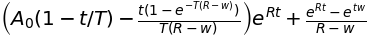

In [ ]:
manual_numerator = (A_0*(-R+w)*(T-t) -(T-t) -t*sym.exp(-(R-w)*T))*sym.exp(R*t) +T*sym.exp(w*t) 
assert sym.simplify(A_max.args[2]*A_max.args[3] - manual_numerator) == 0
A_max_simp = (1/(R-w))*(sym.exp(R*t) - sym.exp(w*t)) + (A_0*(1-t/T) -t/T/(R-w)*(1-sym.exp(-T*(R-w))))*sym.exp(R*t)
assert sym.simplify(A_max_simp - manual_numerator * A_max.args[0]*A_max.args[1]) == 0
A_max_simp

So this is our full solution for $A(t)$. Written out this way, you should be able to convince yourself that for $R>w$ and $t<T$ we always have $A(t) > 0$.

## Visualizing solutions
To get an idea of what this looks like, let's turn it into a Python function and plug in some parameters

In [ ]:
A_max_fn = sym.lambdify([t, R, w, A_0, T], A_max, 'numpy') 

Text(0, 0.5, '$A$')

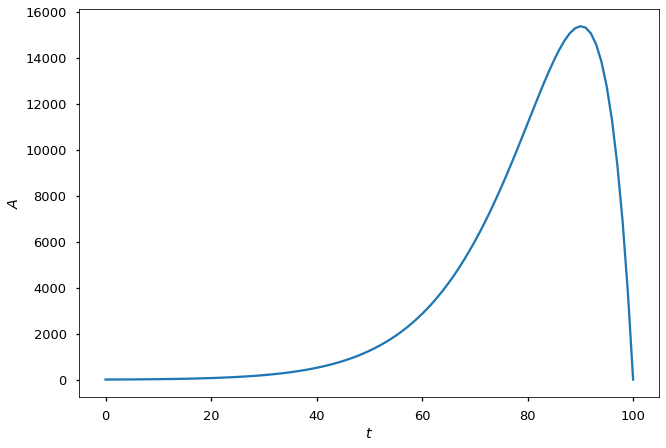

In [ ]:
R_n = 0.1
w_n = 0.05
A_0_n = 0
T_n = 100
t_n = np.linspace(0,T_n,101)
plt.plot(t_n, A_max_fn(t_n, R_n, w_n, A_0_n, T_n))
plt.xlabel('$t$')
plt.ylabel('$A$')

Qualitatively, the optimal behavior is to take advantage of the savings rate to amass weath until some point late in late, and then spend it all by the end—seems reasonable. Let's see if we can the find the time that corresponds to maximum wealth.

In [ ]:
max_A_eq = sym.Eq(A_max_simp.diff(t), 0)
max_A_eq_2 = cancel_eq_denom(cancel_eq_denom(max_A_eq, sym.exp(-R*t)), T*(-R+w))
max_A_eq_2

Simplifying a bit:

In [ ]:
max_A_eq_simp = sym.Eq((-R*A_0*(R-w)*T +A_0*(R-w) - sym.exp(-T*(R-w)) + 1 -R*T) + t*R*(1 - sym.exp(-T*(R-w)) + A_0*(R-w)) + T*w*sym.exp(-t*(R-w)) , 0)
assert sym.simplify(max_A_eq_simp.lhs - max_A_eq_2.lhs) == 0
max_A_eq_simp

At this point we can see that we have a transcendental equation of the form $a +bt+e^{ct}$=0, with some ugly coefficients. We won't bother trying to simplify any furhter, other than to note the solution involves the [Lambert $W$ Function](https://en.wikipedia.org/wiki/Lambert_W_function).

In [ ]:
a, b, c = sym.symbols('a,b,c')
sym.solve(sym.Eq(a + b*t + sym.exp(c*t), 0),t)[0]

We can also check the numeric solution for the parameters we plotted above.

In [ ]:
sym.nsolve(max_A_eq_simp.subs(A_0,A_0_n).subs(R, R_n).subs(w, w_n).subs(T, T_n), T_n/2)

# A more interesting formulation
Now let's make the problem more realistic, if only slightly. We'll incude an exponential discount factor for $\beta$ characterized by a decay rate $\gamma$. We can think of this factor a couple of ways—it could express general time preference, or the declining quality of life as we age. In any case, we can write down our new Lagrangian.

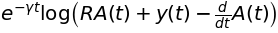

In [ ]:
gamma = sym.Symbol('gamma', positive=True)
L_full = L_explicit.subs(beta(t), sym.exp(-gamma*t)).subs(u, sym.log)
L_full

This leads to a new set of Euler-Lagrange equations.

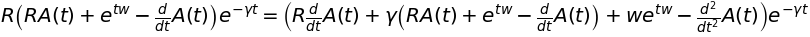

In [ ]:
EL_eq = sym.Eq(L_full.diff(A(t)), L_full.diff(A(t).diff(t)).diff(t))
EL_eq_simple = cancel_eq_denom(EL_eq, c_fn_of_A**2)
EL_explicit = sym.simplify(EL_eq_simple.subs(y(t), y_explicit))
EL_explicit

Unfortunately, our analytical exploration has to stop here. This isn't an easy differential equation anymore (at least not for me or SymPy), so we'll switch to numerics. First let's get an expression for the second derivative.

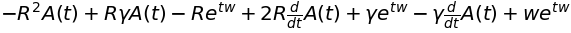

In [ ]:
d2A_sol = sym.simplify(sym.solve(EL_explicit, A(t).diff(t).diff(t))[0])
d2A_sol

And now create our numeric functions.

In [ ]:
d2A_func = sym.lambdify([R, w, gamma,  A(t), A(t).diff(t), t], d2A_sol, 'numpy')
c_func = sym.lambdify([R, w, A(t), A(t).diff(t), t], c_fn_of_A.subs(y(t), y_explicit),  'numpy')

We can use SciPy's [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) routine to get numerical solutions. We'll also need to use a minimization routine to find the right value for our $A'_0$ constant of integration. 

In [ ]:
def numerical_integrate(R, w, gamma, T, A_0, dA_dt_0, n_points = 101):
  ts = np.linspace(0, T, n_points)
  def dV_dt(V, t):
      # V is a vector representing [A, dA/dt]
      return [V[1], d2A_func(R, w, gamma, V[0], V[1], t)]
  V0 = [A_0, dA_dt_0]
  Vs = odeint(dV_dt, V0, ts)
  As = Vs[:,0]
  cs = c_func(R, w, As, Vs[:, 1], ts)
  return ts, As, cs

def find_constraint_ic(R, w, gamma, T, A_0):
  int_fn = functools.partial(numerical_integrate, R, w, gamma, T, A_0)
  constraint = NonlinearConstraint(lambda dA_dt_0: int_fn(dA_dt_0)[1][-1], lb=0, ub=np.inf)
  return minimize(lambda dA_dt_0: -sum(np.log(int_fn(dA_dt_0)[2])), 0, constraints=[constraint])

def constrained_integrate(R, w, gamma, T, A_0, n_points=101):
  dA_dt_0 = find_constraint_ic(R, w, gamma, T, A_0).x[0]
  return numerical_integrate(R, w, gamma, T, A_0, dA_dt_0, n_points)
    

Let's use some interactive widgets so we can explore what the solutions look like.

In [ ]:
def plot_lines(R, w, gamma, T, A_0):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
  ts, As, cs, = constrained_integrate(R, w, gamma, T, A_0, n_points=101)
  ax1.plot(ts, As)
  ax2.plot(ts, cs)
  ax1.set_xlabel('$t$')
  ax1.set_ylabel('$A$')
  ax2.set_xlabel('$t$')
  ax2.set_ylabel('$c$')

    
ipywidgets.interact(
    plot_lines,
    R = ipywidgets.FloatSlider(value=0.05, min=0, max=0.05, step=0.001, readout_format='.3f'),
    w = ipywidgets.FloatSlider(value=0.03, min=0, max=0.05, step=0.001, readout_format='.3f'),
    gamma = ipywidgets.FloatSlider(value=0.03, min=0, max=0.05, step=0.001, readout_format='.3f'),
    T = ipywidgets.IntSlider(value=100, min=1, max=100, step=1),
    A_0 = ipywidgets.IntSlider(value=35, min=0, max=100, step=1),
)

interactive(children=(FloatSlider(value=0.05, description='R', max=0.05, readout_format='.3f', step=0.001), Fl…

<function __main__.plot_lines>

One of the things that jumps out here is that we now see the behavior of borrowing: depending on the different parameters, wealth decreases below zero, only to recover to zero by the final time. Intuitively this makes sense; for large discount factors, we should try to consume as much as possibe at early times even if that means having interest work against us when we're old.
## Exploring parameter regimes
In order to see how borrowing depends on the parameters of the problem, let's plot the maximum and minimum wealth as functions of $\beta$ and $w$ for a fixed $R$. 

In [ ]:
def plot_max_and_min_A(A_0):
  n_grid = 41
  R = 0.025
  ws = np.linspace(0, 1, n_grid) * R
  gammas = np.linspace(0, 2, n_grid) * R
  max_As = np.empty((n_grid,n_grid))
  min_As = np.empty((n_grid,n_grid))
  for i, w in enumerate(ws):
    for j, gamma in enumerate(gammas):
      ts, As, cs = constrained_integrate(R, w, gamma, 100, A_0)
      max_As[i,j] = As.max()
      min_As[i,j] = As.min()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
  c1 = ax1.pcolor(gammas/R, ws/R, max_As, cmap='seismic', vmin=-100, vmax=100)
  plt.colorbar(c1, ax=ax1)
  c2 = ax2.pcolor(gammas/R, ws/R, min_As, cmap='seismic', vmin=-100, vmax=100)
  plt.colorbar(c2, ax=ax2)
  ax1.set_xlabel('$\gamma$ / $R$')
  ax1.set_ylabel('$w$ / $R$')
  ax1.set_title('Max $A$')
  ax2.set_xlabel('$\gamma$ / $R$')
  ax2.set_ylabel('$w$ / $R$')
  ax2.set_title('Min $A$')


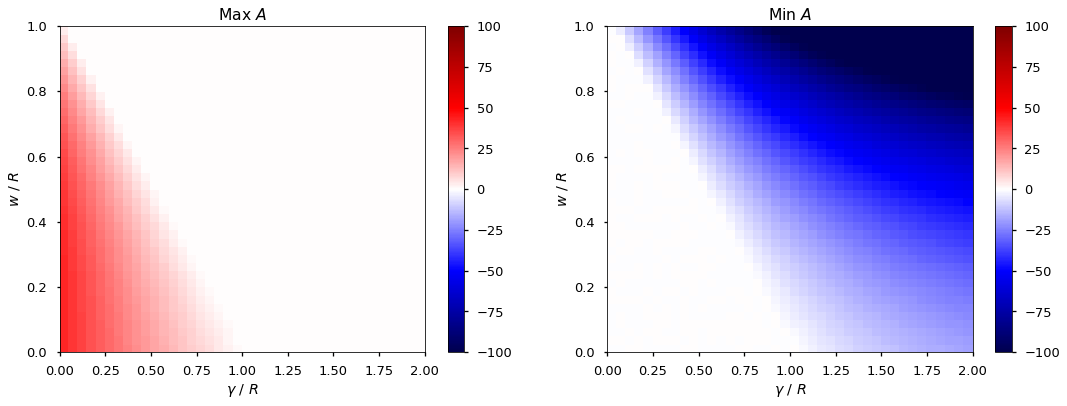

In [ ]:
plot_max_and_min_A(0)

For zero initial wealth, we can see a roughly linear boundary in $w$ vs. $\gamma$ separating the two regimes. For small $\gamma$ and $w$, wealth is always positive (the saving regime), and for large $\gamma$ and $w$, wealth is always negative (the borrowing regime). Let's see how starting with some initial wealth changes this picture.

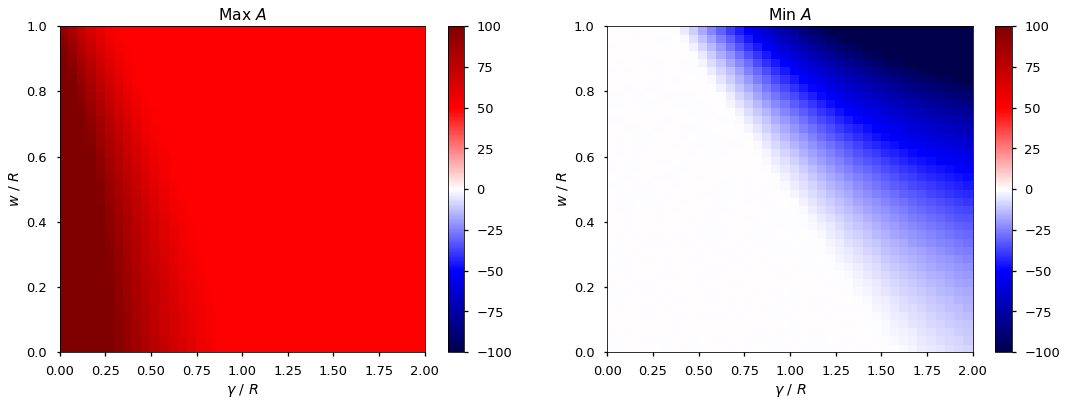

In [ ]:
plot_max_and_min_A(50)

The story is broadly the same: there's a saving regime in the lower left, and a borrowing regime in the upper right. But it appears that there's also a finite region of of small $w$ and intermediate $\gamma$ where neither saving nor borrowing occurs: wealth just monotonically decreases to zero at the final time. Additionally, we see that the boundaries of the regimes move and change slope. 

Overall, this shows that the behaviors associated with the simple goal of maximizing lifetime utility can be very different dependent on the parameters and initial conditions of the problem.

# Possible extensions
Of course, this is still very much a toy model. We could add to it in a number of ways, like having a more realistic model of labor income (perhaps with a cutoff retirement age, or an asymmetric log-normal distribution?). We could also play with the contraints we impose to prevent unbounded borrowing. One such possibilty is requiring that the average wealth over the time period $[0,T]$ is greater than zero.

For this constraint, we would have to introduce the use of Lagrange multipliers. Our Lagrangian would then look like 
$$L=\beta(t)u(RA(t) +y(t)-\frac{d}{dt}A(t)) - \lambda A(t)$$ 
where $\lambda >0$ is the constraint force.

How would a constraint like this change what wealth at the end of life looks like?

Indeed, we could think of many more interesting constraints to impose on the problem, though if the constraint is [nonholonomic](https://en.wikipedia.org/wiki/Nonholonomic_system) our calculus of variations approach is unlikely to be successful.